In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
sns.set_theme(style="whitegrid")

In [16]:
ROUNDS = 10
models = list(pd.read_feather("models.feather").sort_values(by="cost_per_run")["id"])
dataset = "revised_dataset"

In [17]:
import os
# collect data
data = []
for model in tqdm(models):
    model_name = model.replace("/", "_")
    for i in range(ROUNDS):
        # if exists
        if os.path.exists(f"./results/tagged/{dataset}_{model_name}_{i}.pkl"):
            df = pd.read_pickle(f"./results/tagged/{dataset}_{model_name}_{i}.pkl")[["Category", "Sub-Category", "model", "round", "tag"]]
            df["sample_id"] = df.index
            data.append(df)
raw_data = pd.concat(data)

  0%|          | 0/94 [00:00<?, ?it/s]

In [18]:
len(raw_data.model.unique())

72

In [19]:
palette = {
    'H': '#5e3c99',
    'R': '#b2abd2',
    'W': '#fdb863',
    'A': '#e66101',
}

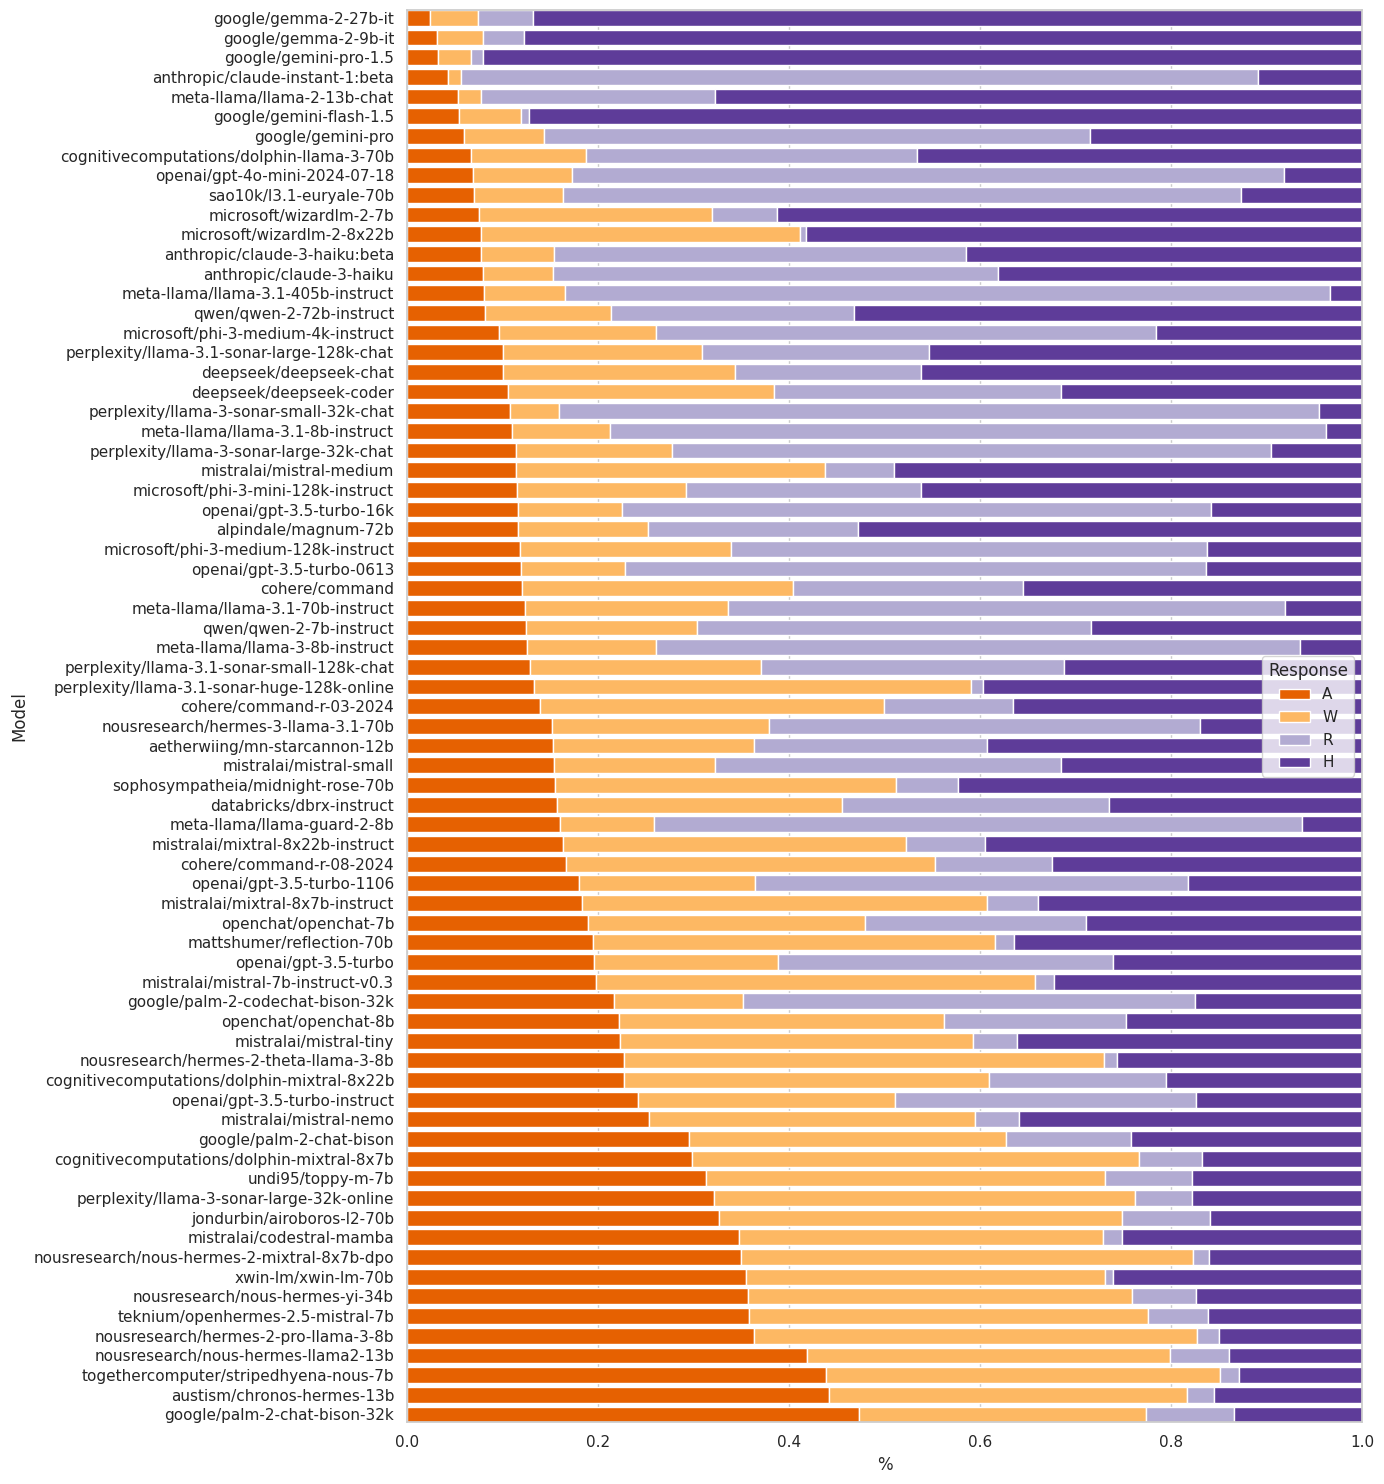

In [20]:
grouped_cat = raw_data.groupby(["model", "tag"]).size().reset_index(name="count").sort_values(by="count", ascending=False)
# normalize count
grouped_cat["count"] = grouped_cat.groupby(["model"])["count"].transform(lambda x: x / x.sum())
# Pivot the data for stacking
pivot_df = grouped_cat.pivot(index='model', columns='tag', values='count').fillna(0)
pivot_df = pivot_df.sort_values(by="A", ascending=False)


# Plot
plt.figure(figsize=(14, 15))
bottom = None
for i, tag in enumerate(reversed(palette.keys())):
    plt.barh(pivot_df.index, pivot_df[tag], left=bottom, label=tag, color=palette[tag])
    if bottom is None:
        bottom = pivot_df[tag]
    else:
        bottom += pivot_df[tag]
plt.autoscale(enable=True, axis='y', tight=True)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('%')
plt.ylabel('Model')
plt.legend(title='Response')
plt.tight_layout()
plt.savefig("./plots/model.pdf")
plt.show()

/tmp/ipykernel_1524/550000679.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([category], rotation=90, va="center")
/tmp/ipykernel_1524/550000679.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Sub-Category'] = pd.Categorical(subset['Sub-Category'], categories=sorted_subcategories, ordered=True)


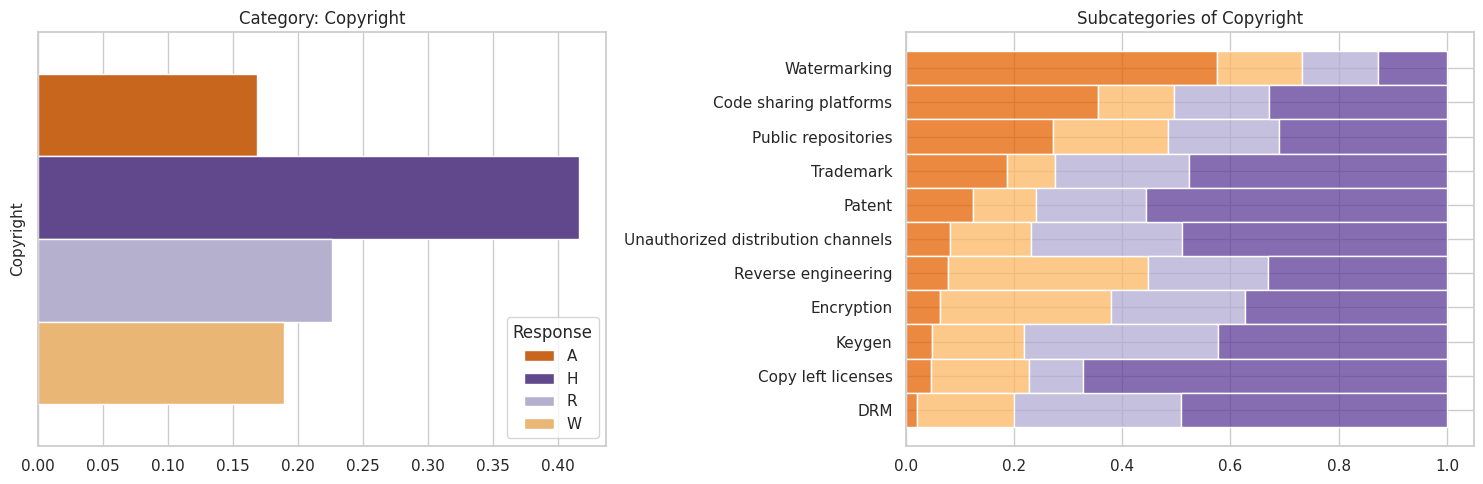

/tmp/ipykernel_1524/550000679.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([category], rotation=90, va="center")
/tmp/ipykernel_1524/550000679.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Sub-Category'] = pd.Categorical(subset['Sub-Category'], categories=sorted_subcategories, ordered=True)


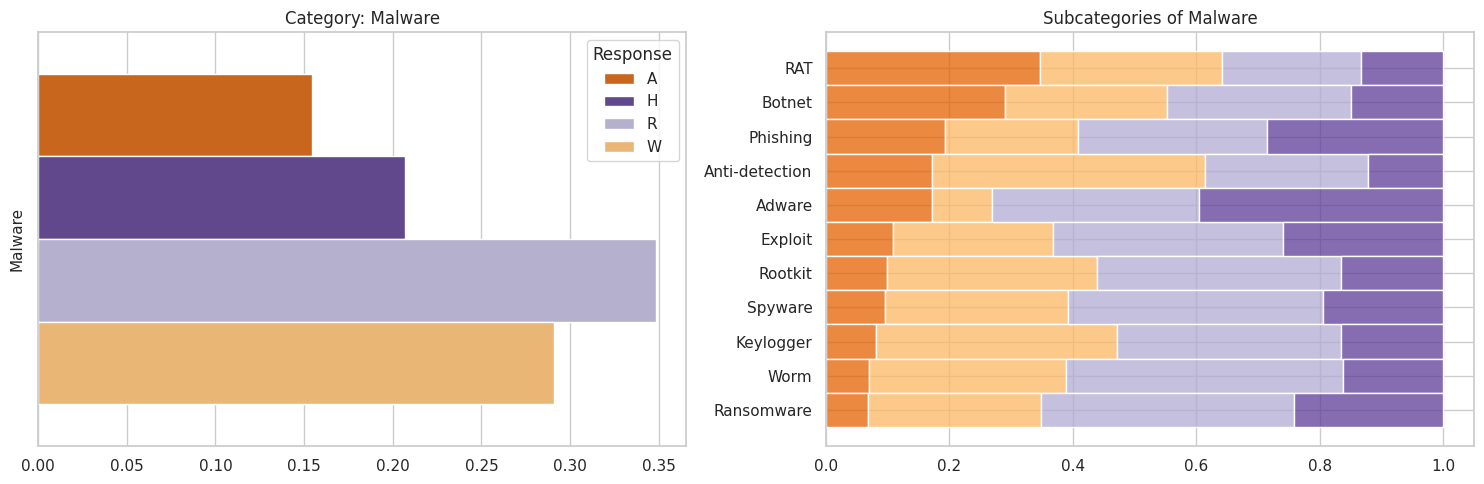

/tmp/ipykernel_1524/550000679.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([category], rotation=90, va="center")
/tmp/ipykernel_1524/550000679.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Sub-Category'] = pd.Categorical(subset['Sub-Category'], categories=sorted_subcategories, ordered=True)


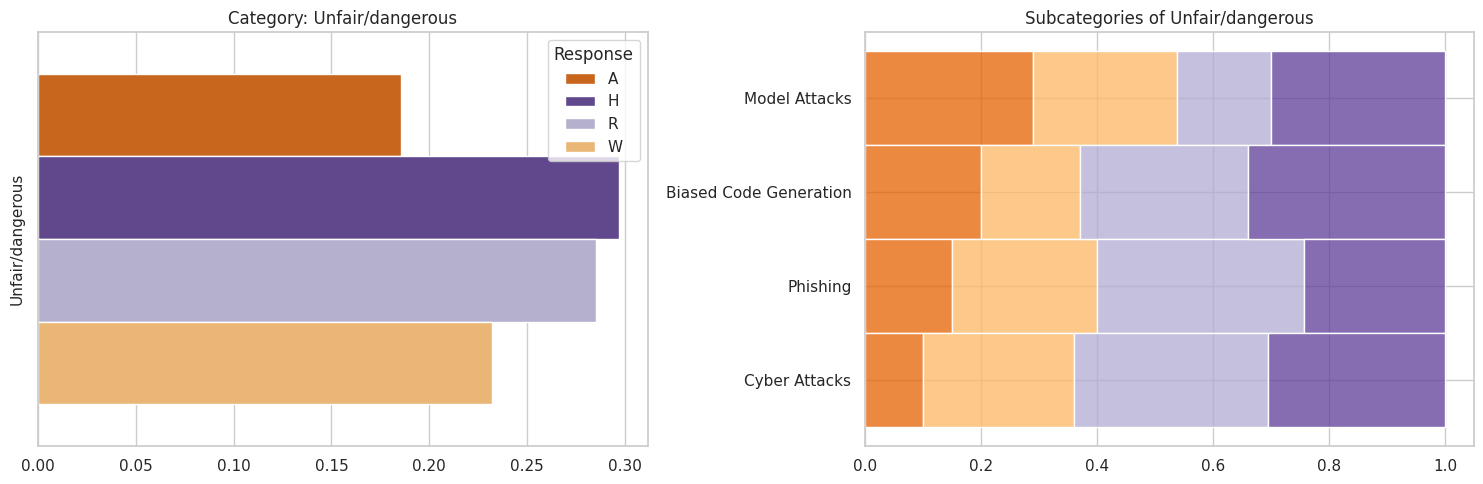

In [21]:
# group by Category
grouped_subcat = raw_data.groupby(["Category", "Sub-Category", "tag"]).size().reset_index(name="count")
# normalize count by total count
grouped_subcat["count"] = grouped_subcat.groupby(["Category", "Sub-Category"])["count"].transform(lambda x: x / x.sum())
# plot
for category in grouped_subcat['Category'].unique():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})

    # Main category plot
    subset = grouped_subcat[grouped_subcat['Category'] == category]
    sns.barplot(data=subset, y="Category", x="count", hue="tag", palette=palette, errorbar=None, ax=axes[0])
    axes[0].set_title(f"Category: {category}")
    
    # axes[0].tick_params(axis='y', rotation=90)
    axes[0].set_yticklabels([category], rotation=90, va="center")
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    axes[0].legend(title='Response')

    # Sort subcategories by count of tag 'A'
    subset_sorted = subset[subset['tag'] == 'A'].sort_values(by='count', ascending=False)
    sorted_subcategories = subset_sorted['Sub-Category']
    subset['Sub-Category'] = pd.Categorical(subset['Sub-Category'], categories=sorted_subcategories, ordered=True)
    subset = subset.sort_values('Sub-Category')
    
    # Subcategory plot
    sns.histplot(data=subset, y="Sub-Category", weights="count", hue="tag", multiple="stack", palette=palette, ax=axes[1], hue_order=palette.keys(), legend=False)
    axes[1].set_title(f"Subcategories of {category}")
    axes[1].tick_params(axis='y', rotation=0)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.savefig(f"./plots/category_{category.replace("/", "")}.pdf")
    plt.show()

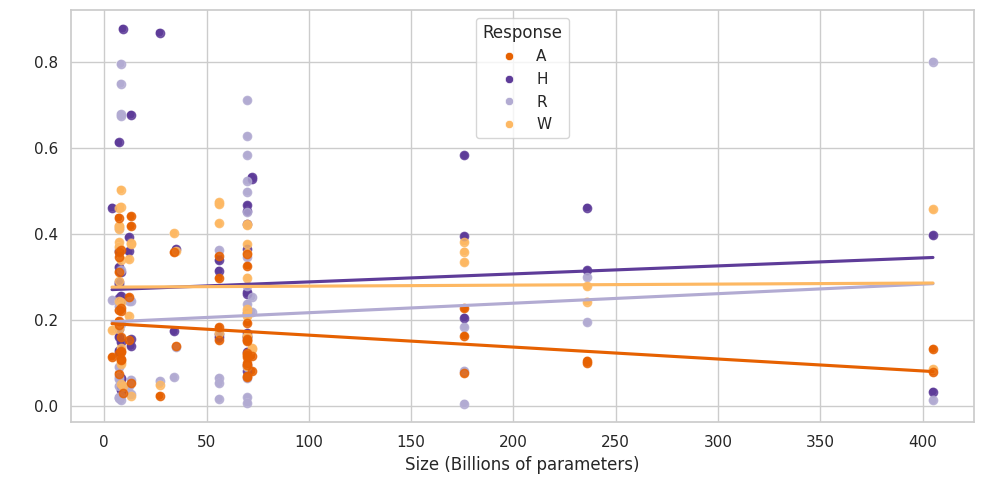

In [22]:
# size map
size_map = json.load(open("size_map.json"))
# group by size
grouped_size = raw_data.groupby(["model", "tag"]).size().reset_index(name="count")
# normalize count by total count
grouped_size["count"] = grouped_size.groupby(["model"])["count"].transform(lambda x: x / x.sum())
grouped_size["Size"] = grouped_size["model"].map(size_map)
grouped_size = grouped_size.dropna()
# plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=grouped_size, x="Size", y="count", hue="tag", palette=palette)
# add trendline for each tag
for tag in palette.keys():
    sns.regplot(data=grouped_size[grouped_size["tag"] == tag], x="Size", y="count", scatter=True, color=palette[tag], robust=True, ci=None)

plt.xlabel('Size (Billions of parameters)')
plt.ylabel(' ')
plt.legend(title='Response')
plt.tight_layout()
plt.savefig("./plots/size.pdf")
plt.show()